In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Part 1

In [2]:
#load in json data
login = pd.read_json(r'logins.json')
login

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
#set index into a datetime and drop the login time column 
#create a num column equal to 1 since there is 1 login for every index
login['login_time'] = pd.to_datetime(login['login_time'])
login.set_index(login['login_time'], inplace=True)
login.drop(columns=['login_time'], inplace=True)
login['num'] = 1
login

,num
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [4]:
#aggregate into 15 minute intervals and calculate the sum of logins in each of the intervals
login_15 = login.resample('15min').sum()
login_15

,num
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


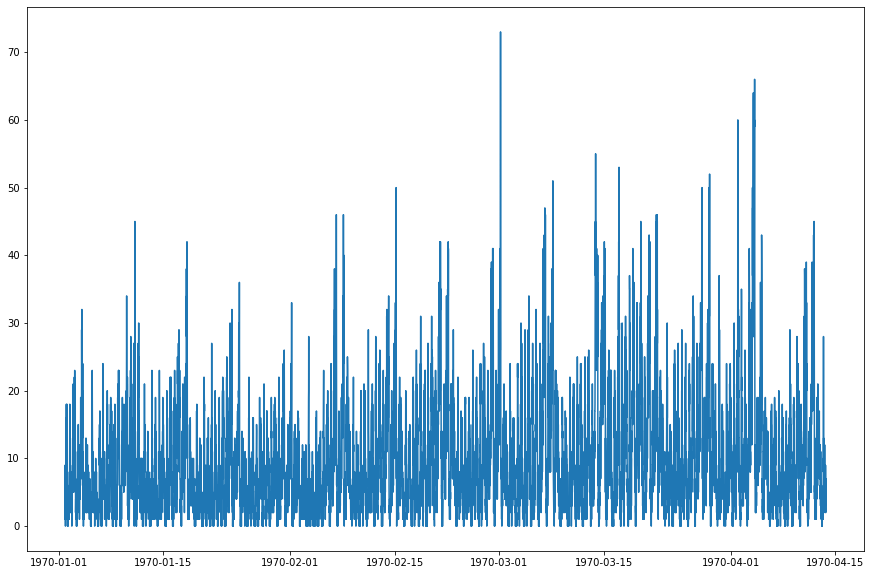

In [5]:
#plot the logins
plt.figure(figsize=(15,10))
plt.plot(login_15)

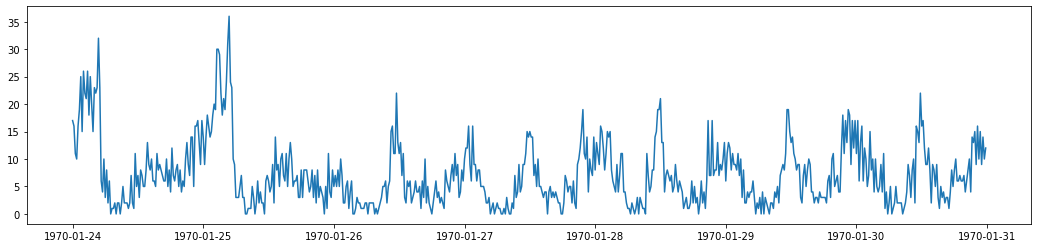

In [6]:
#plot the logins on a smaller interval since we can see there is a pattern but it is covered with so much data
#dropping down to a two week plot interval
plt.figure(figsize = (18,4))
plt.plot(login_15[2128:2800])

In [7]:
login_15.describe()

,num
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Looking at the first data we can definitely see that there is a pattern of peaks and troughs within the data but it's hard to tell within the first graph since it covers months of data in 15 minute intervals

In the second graph which only spans a week we can see a more clear pattern of large spikes of logins in the beginning of the day before going down later in the day. There is also mini spikes within consistent time intervals throughout the day as well. 

# Part 2

1. Due to the opposing circadian rhythms, Metropolis being active in day and Gotham at night during the weekdays, encouraging drivers to be active in both cities on the weekdays would not be feasible. Drivers most likely want to be active during peak times of activity and doing double shifts would turn most people away. So what I propose is they keep the toll active on weekdays and then make the toll free for drivers on the weekends to encourage more activity between the two cities on the weekends. 

2. As for an experiment to test these results, the Ultimate managers of the cities should request for the driving data from drive sharing apps which would be the control data for the experiment. Then implementing the change of the tolls on the weekends for drivers and tracking the data of drivers traveling between the cities would be the start. Using z-test to take the averages of city travel productivity and overall revenue (including weekday and weekend) and comparing those averages before the change and after the change would be the rough draft implementation of the experiment. Calculating for statistical significance with a p-value less than that of 0.05, and then also calculating for price and cost value in the sense of knowing whether or not the change is worth implementing. You should also implement other control variables such as making sure the there are no outside variables affecting the experiment such as a freak massive accident causing a massive shutdown of the toll or holiday seasons boosting productivity. This would be the types of things to implement in the experiment. 

# Part 3

For part 3 we are going to work on finding out how we can predict rider retention. We are going to do some rough analysis by looking at the columns and their info and statistical features, find out who is our active users and visually compare them with each feature through a graph with their line of best fit, clean and pred the data and use it to build a model. For this model we are going to use logistic regression since we are dealing with classification, specifically binary classification. 

In [8]:
challenge = pd.read_json(r'ultimate_data_challenge.json')
challenge

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [9]:
challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


So far we see we have a good mix of integers, floats, objects, and then 1 boolean. This means we probably are going to have to use some dummy variables. We also have some missing data so we may have to drop or impute. 

In [10]:
challenge.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


So far we have a wide range of variables and those variables have a wide range of numbers within themselves. It's hard to tell what is what and so we might have to scale things a little later on when we build our model. However based on some of the initial info and what each feature does, I have some thoughts on which ones could be important for rider retention. So far my predictions are that avg_dist and avg_rating_of_driver could be important. If a person has to travel far, it might push a person away from using a rider service due to costs of it and they might look for cheaper options such as a bus. The rating of drivers could be important as well since people could potentially die or get car sick if a driver is bad. They might form a bias around rider services as well due to this. However these are just initial thoughts

Next we shall look at who is our active users and compare them with each feature graphically. 

In [11]:
active = []
for i in range(len(challenge)):
    start = pd.Timestamp(challenge['signup_date'][i]) #get start date
    end = start + pd.Timedelta('181D') #6 months later
    activity = end - pd.Timedelta('30D') #set point 30 days prior
    if activity <= pd.Timestamp(challenge['last_trip_date'][i]) <= end:
        active.append([1]) # now that the active condition has been met, set active user to 1
    else:
        active.append([0])

In [12]:
active_df = pd.DataFrame(active, columns=['active_user'])

0    37802
1    12198
Name: active_user, dtype: int64

<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='active_user'>

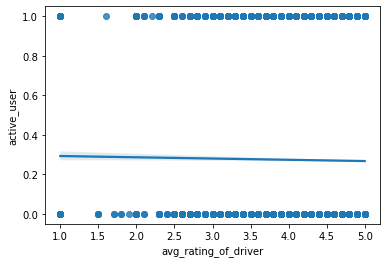

In [14]:
sns.regplot(x=challenge['avg_rating_of_driver'], y=active_df['active_user'], fit_reg=True)

<AxesSubplot:xlabel='avg_rating_by_driver', ylabel='active_user'>

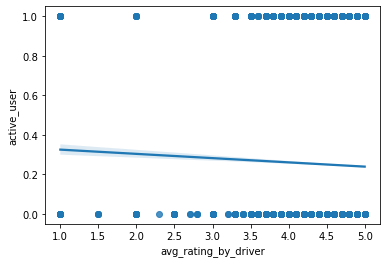

In [15]:
sns.regplot(x=challenge['avg_rating_by_driver'], y=active_df['active_user'], fit_reg=True)

<AxesSubplot:xlabel='avg_dist', ylabel='active_user'>

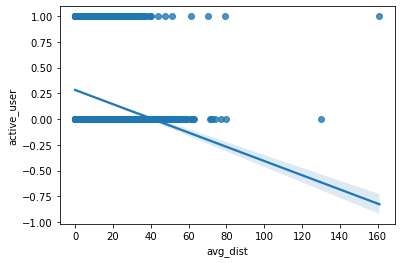

In [16]:
sns.regplot(x=challenge['avg_dist'], y=active_df['active_user'], fit_reg=True)

<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='active_user'>

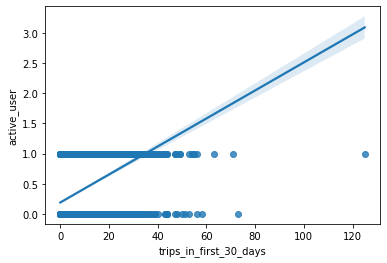

In [17]:
sns.regplot(x=challenge['trips_in_first_30_days'], y=active_df['active_user'], fit_reg=True)

<AxesSubplot:xlabel='avg_surge', ylabel='active_user'>

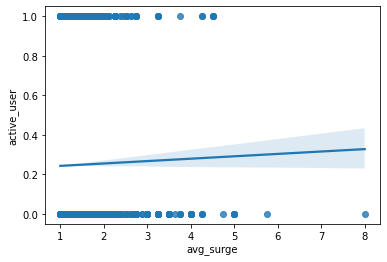

In [18]:
sns.regplot(x=challenge['avg_surge'], y=active_df['active_user'], fit_reg=True)

<AxesSubplot:xlabel='weekday_pct', ylabel='active_user'>

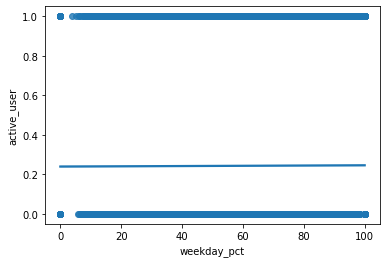

In [19]:
sns.regplot(x=challenge['weekday_pct'], y=active_df['active_user'], fit_reg=True)

Based on the graphs we can see that there are some things that have strong associations and others that don't. The best ones are avg_dist with a negative correlation and trips_in_first_30_days which has a strong positive correlation. The other ones have slight correlations or almost none at all. 

We are going to drop some columns. avg_rating_of_driver is going to get dropped even though I would like to keep it in. It has too much missing data I don't think imputing all of it would be beneficial to the model. signup_date and last_trip_date will also be dropped since randomized dates based on user doesn't seem to create any pattern that will be beneficial in predictions. phone is dropped since the type of phone shouldn't matter too much in rider retention but rather the app itself and weekday_pct didn't seem to have any correlation at all to active user so we will remove it to make things easier for the model. 

After that we will impute missing values and also prep our data by encoding it and creating dummy variables. 

In [20]:
df = pd.concat([challenge, active_df], axis=1)
df.drop(columns=['avg_rating_of_driver', 'phone', 'signup_date', 'last_trip_date', 'weekday_pct', ], inplace=True)

In [21]:
df.isnull().sum()

city                        0
trips_in_first_30_days      0
avg_surge                   0
surge_pct                   0
ultimate_black_user         0
avg_dist                    0
avg_rating_by_driver      201
active_user                 0
dtype: int64

In [22]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df.isnull().sum()

city                      0
trips_in_first_30_days    0
avg_surge                 0
surge_pct                 0
ultimate_black_user       0
avg_dist                  0
avg_rating_by_driver      0
active_user               0
dtype: int64

In [23]:
df['ultimate_black_user'].replace({False:0, True:1}, inplace=True)
df

,city,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,1.10,15.4,1,3.67,5.0,0
1,Astapor,0,1.00,0.0,0,8.26,5.0,0
2,Astapor,3,1.00,0.0,0,0.77,5.0,0
3,King's Landing,9,1.14,20.0,1,2.36,4.9,1
4,Winterfell,14,1.19,11.8,0,3.13,4.9,0
...,...,...,...,...,...,...,...,...
49995,King's Landing,0,1.00,0.0,0,5.63,4.2,0
49996,Astapor,1,1.00,0.0,0,0.00,4.0,0
49997,Winterfell,0,1.00,0.0,1,3.86,5.0,0
49998,Astapor,2,1.00,0.0,0,4.58,3.5,0


In [24]:
dummy = pd.get_dummies(df['city'])
df = pd.concat([df, dummy], axis=1)
df.drop(columns=['city'], inplace=True)

In [25]:
X = df.drop(columns = ['active_user']) 
y = df['active_user']

Before we begin the model process we need to scale the data. Scaling the data will be useful since a lot of the things seem to be on different scales and this will help the model learn better. We will use a simple MinMaxScaler. 

From there we are going to try some different modeling. First a simple LogisticRegression model and then move onto a optimized LogisticRegression model through GridSearchCV

In [32]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [35]:
print(confusion_matrix(y_test,y_pred))

[[9129  315]
 [2656  400]]


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      9444
           1       0.56      0.13      0.21      3056

    accuracy                           0.76     12500
   macro avg       0.67      0.55      0.54     12500
weighted avg       0.72      0.76      0.70     12500



So far we have an okay model. Overall accuracy is 76% based on the classification report. Now lets optimize with our C a bit and with that it should improve our model and then we can take a look at our feature importance and their coefficients. 

In [38]:
param_grid = {'C':np.arange(0.1, 5, 0.1)}

lr_cv = GridSearchCV(lr, param_grid=param_grid, cv=5)

lr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])})

In [39]:
lr_cv.best_estimator_.C

4.1

In [56]:
lr_4_1 = LogisticRegression(C=4.1) 
lr_4_1.fit(X_train, y_train)

y_pred_2 = lr_4_1.predict(X_test)
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      9444
           1       0.57      0.14      0.23      3056

    accuracy                           0.76     12500
   macro avg       0.67      0.55      0.54     12500
weighted avg       0.73      0.76      0.71     12500



Overall things improved slightly but for the most part it is the same. We can definitely build a more defined model with another classifier and optimizing the hyperparameters but this is still okay for a rough draft. Let's look at the feature importance to conclude this. 

In [57]:
features = df.drop(columns=['active_user']).columns
coef = lr_4_1.coef_[0]

best_features = list(zip(features, coef))
best = pd.DataFrame(best_features, columns = ['Features', 'Coef'])
best.sort_values('Coef', ascending=False)

,Features,Coef
0,trips_in_first_30_days,12.246237
3,ultimate_black_user,0.728114
7,King's Landing,0.470383
2,surge_pct,0.453105
8,Winterfell,-0.301644
5,avg_rating_by_driver,-0.530774
1,avg_surge,-0.700500
6,Astapor,-0.780984
4,avg_dist,-6.177921


# Conclusion

Based on feature importance trips_in_first_30_days and avg_dist are the most important. The more trips in the first 30 days of a user seem to retain them a lot so Ultimate should try to get users to take a lot of trips in their first 30 days through deals or some promotion of sorts. This may be due to that the first 30 days forms a strong impression that keeps the user active or helps them to believe that Ultimate has good usage encouraging them to use it more. avg_dist shows that the longer the distance, the less likely the user is to stay on Ultimate. This may be due to costs or just better options. So Ultimate should maybe offer promotions or deals for longer rides or rather focus more on local users who don't travel as far and capitalize on them instead of users who travel longer distances. 